Ornstein-Uhlenbeck (OU) process:

It is a popular stochastic differential equation (SDE) to model mean-reverting spreads between two correlated assets.

Before fitting an OU process, ensure that the two assets are cointegrated (i.e., their spread is mean-reverting).

Common methods:
Engle-Granger Test (ADF test on residuals of a linear regression).
Johansen Test (for multiple assets).

$$
dc_t = \kappa (\theta - c_t)\,dt + \sigma\,dW_t
$$


Model the spread as a discrete-time OU process:
$$
\text{Spread}_{t+1} = a + b \cdot \text{Spread}_t + \eta_t
$$
Estimate parameters a and b using linear regression of 
$$
\text{Spread}_{t+1} on  

\text{Spread}_t. 
$$
Then, compute the OU parameters:
	•	Mean reversion rate (κ): 
    $$
    \kappa = -\ln(b) / \Delta t
    $$
	•	Long-term mean (θ): 
    $$
    \theta = a / (1 - b)
    $$
	•	Volatility (σ): 
    $$
    \sigma = \text{std}(\eta_t) \cdot \sqrt{2\kappa / (1 - b^2)}
    $$
Assume 
$$
\Delta t = 1/252 
$$
for daily data.

When ADF P value =0.9499, it is much greate than 0.05, meaning we fail to reject null hypotheis, that time series has a unit root, i.e. it is non-stationary.

stationary implies constant mean and variance, then we can say two stock are cointegrated

Half - life=ln(2)/k, for instance, if k=74.43 for the data by minute, then half - life = 0.0093 years, or 0.0093 * (252 days) * (390 min) = 914 minutes, or 2.3 trading day


In [2]:

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from itertools import combinations
import os

def get_csv_files(path, filename):
    full_path = os.path.join(path, filename)
    df=pd.read_csv(full_path)
    ticker=df['ticker'].unique().tolist()
    price_data = df.pivot_table(index='Datetime', columns='ticker', values='Close')
    return price_data, ticker

path = '/Users/jayren/Desktop/stock/Stock_Daily'
dailydata = '/Users/jayren/Desktop/stock/stock_Daily/dailydata'
consolidated = '/stockPrice_consolidated'


#us: us_stock_price.csv
# ca: ca_stock_price.csv
# adhoc: adhoc_stock_price.csv


price_data, tickers = get_csv_files(
    path=os.path.join(dailydata+consolidated), 
    filename='us_stock_price.csv'
)
# return price_data, ticker

In [3]:
#using AD fuller test to check for cointegration


import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Download data (example: SPY vs. XLE)
tickers = ["GOOGL", "MSFT"]
data = yf.download(tickers, start="2020-01-01", end="2025-12-31")["Close"]
data = data.dropna()

# ticker=['googl', 'aal']
# tickers=[tik.upper() for tik in ticker]
# data = price_data[tickers]


pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
np.set_printoptions(threshold=np.inf)


data.index = pd.to_datetime(data.index)
#data = data.asfreq('min')  # 'T' = 1-minute frequency
data = data.dropna()

# Cointegration test using Engle-Granger 2-step method
def check_cointegration(y, x):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    spread = y - model.predict(sm.add_constant(x))  # more robust
    adf_stat, p_value, _, _, crit_values, _ = adfuller(spread)
    
    print("ADF Statistic:", round(adf_stat, 4))
    print("ADF p-value:", round(p_value, 4))
    print("Critical Values:", crit_values)
    
    if p_value < 0.05:
        print("✅ Residuals are stationary ⇒ series are cointegrated.")
    else:
        print("❌ Residuals are non-stationary ⇒ no cointegration.")
    
    return spread, p_value

# Run the test
spread, p_value = check_cointegration(data[tickers[0]], data[tickers[1]])

print(data.tail(5))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed

ADF Statistic: -2.9013
ADF p-value: 0.0452
Critical Values: {'1%': np.float64(-3.4351852261663867), '5%': np.float64(-2.863675384893896), '10%': np.float64(-2.5679068804891)}
✅ Residuals are stationary ⇒ series are cointegrated.
Ticker           GOOGL        MSFT
Date                              
2025-05-19  166.539993  458.869995
2025-05-20  163.979996  458.170013
2025-05-21  168.559998  452.570007
2025-05-22  170.869995  454.859985
2025-05-23  168.470001  450.179993


In [4]:

# this is chatGPT code
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# # Step 1: Define tickers and download data
# tickers = ['GOOGL', 'MSFT']
# data = yf.download(tickers, start="2020-01-01", end="2025-12-31")['Close']
# data = data.dropna()

# Step 2: Co-integration regression: tickers[0] ~ tickers[1]
X = sm.add_constant(data[tickers[1]])
ols_model = sm.OLS(data[tickers[0]], X).fit()
beta = ols_model.params[tickers[1]]
alpha = ols_model.params['const']

# Step 3: Construct the spread
spread = data[tickers[0]] - (alpha + beta * data[tickers[1]])

# Step 4: Estimate AR(1) model for the spread
spread_lag = spread.shift(1).dropna()
spread_next = spread.loc[spread_lag.index]
X_ar = sm.add_constant(spread_lag)

ar_model = sm.OLS(spread_next, X_ar).fit()
a_hat = ar_model.params['const']
b_hat = ar_model.params[0]
resid_std = ar_model.resid.std(ddof=1)

# Step 5: Convert to OU process parameters
dt = 1/252  # daily frequency
#dt=1/(252*390) # 1 minute frequency

kappa = -np.log(b_hat) / dt
theta = a_hat / (1 - b_hat)
sigma = resid_std * np.sqrt(2 * kappa / (1 - b_hat**2))
halflife = np.log(2) / kappa

# Step 6: Print the estimated parameters
print("Ornstein-Uhlenbeck (OU) Parameter Estimates:")
print(f"  Hedge ratio (β):        {beta:.4f}")
print(f"  Intercept (α):          {alpha:.4f}")
print(f"  AR(1) intercept (a):    {a_hat:.6f}")
print(f"  AR(1) slope (b):        {b_hat:.6f}")
print(f"  Mean reversion (κ):     {kappa:.4f}")
print(f"  Long-run mean (θ):      {theta:.4f}")
print(f"  Volatility (σ):         {sigma:.4f}")
print(f"  Half-life:             {halflife:.4f} days")

# Step 7: Plot the spread and long-run mean
import plotly.graph_objects as go

def plot_spread_and_ou_mean_plotly(spread, theta, tickers):
    fig = go.Figure()

    # Plot the spread
    fig.add_trace(go.Scatter(
        x=spread.index,
        y=spread,
        mode='lines',
        name=f'Spread: {tickers[0]} - β·{tickers[1]}',
        line=dict(color='black'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Spread: %{y:.2f}<extra></extra>'
    ))

    # Add the estimated mean (θ) line
    fig.add_trace(go.Scatter(
        x=spread.index,
        y=[theta] * len(spread),
        mode='lines',
        name=f'Estimated Mean (θ = {theta:.2f})',
        line=dict(color='red', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>θ: %{y:.2f}<extra></extra>'
    ))

    # Layout settings
    fig.update_layout(
        title='Co-integration Spread and Estimated OU Mean',
        xaxis=dict(
            title='Date',
            hoverformat='%Y-%m-%d'
        ),
        yaxis_title='Spread',
        template='plotly_white',
        height=500,
        legend=dict(x=0, y=1.1, orientation='h'),
        hovermode='x unified'
    )

    fig.show(renderer="browser")

plot_spread_and_ou_mean_plotly(spread, theta, tickers)

Ornstein-Uhlenbeck (OU) Parameter Estimates:
  Hedge ratio (β):        0.3817
  Intercept (α):          9.2140
  AR(1) intercept (a):    -0.009518
  AR(1) slope (b):        0.987219
  Mean reversion (κ):     3.2415
  Long-run mean (θ):      -0.7447
  Volatility (σ):         30.2166
  Half-life:             0.2138 days


               kappa      theta      sigma  half_life
Date                                                 
2025-05-19  0.022952  -21.48804  42.308953   30.19951
2025-05-20  0.023803 -23.045961   42.17371  29.120521
2025-05-21  0.016294 -35.509756  42.377518  42.540712
2025-05-22  0.031533 -13.310203  44.324869  21.981452
2025-05-23  0.033034 -11.630744  44.395847  20.982864


<Axes: title={'center': 'Rolling OU Parameters (60-minute window)'}, xlabel='Date'>

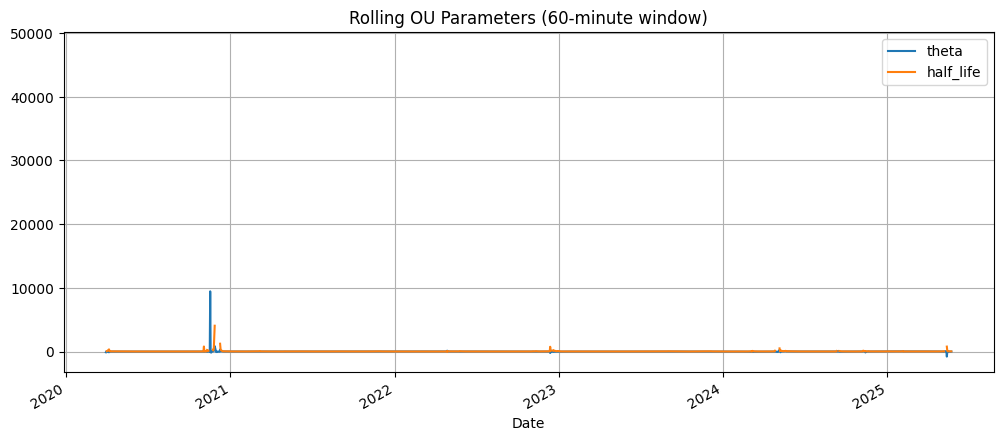

In [5]:
#deepseek method: estimate the parameters of the OU process using a rolling window

def estimate_ou_params(spread, window=30):
    params = pd.DataFrame(index=spread.index, columns=["kappa", "theta", "sigma", "half_life"])
    
    #dt = 1 / (252 * 390)  # 1 minute = 1 / (252*390) years
    
    dt = 1 / 252  # daily frequency

    for i in range(window, len(spread)):
        current_spread = spread.iloc[i - window:i]
        X_t = current_spread[:-1].values
        dX = np.diff(current_spread.values)
        
        # Fit AR(1): dX = a + b * X_t + noise
        model = sm.OLS(dX, sm.add_constant(X_t)).fit()
        a, b = model.params
        resid_std = np.std(model.resid, ddof=1)
        
        # Convert AR(1) coefficients to OU parameters
        kappa = -b
        theta = -a / b if b != 0 else np.mean(current_spread)  # long-run mean
        sigma = resid_std / np.sqrt(dt)
        half_life = np.log(2) / kappa if kappa > 0 else np.inf
        
        params.iloc[i] = [kappa, theta, sigma, half_life]
    
    return params.dropna()

# Estimate parameters with rolling window
ou_params = estimate_ou_params(spread, window=60)
print(ou_params.tail())

# Plot selected parameters
ou_params[['theta', 'half_life']].plot(title="Rolling OU Parameters (60-minute window)", figsize=(12, 5), grid=True)

In [77]:
def generate_signals(spread, params, k=1.5):
    signals = pd.DataFrame(index=spread.index, columns=["Signal"])
    signals["Spread"] = spread
    signals["Theta"] = params["theta"]
    signals["Sigma"] = params["sigma"]
    
    # Z-score for deviation from long-run mean
    signals["Z"] = (signals["Spread"] - signals["Theta"]) / signals["Sigma"]
    
    # Long when spread is too low, short when too high
    signals["Signal"] = np.where(signals["Z"] < -k, 1, np.where(signals["Z"] > k, -1, 0))
    
    return signals.dropna()

signals = generate_signals(spread, ou_params, k=1.5)
print(signals.tail())

import plotly.graph_objects as go

def plot_ou_trading_signals_plotly(spread, signals, k=1.5, title="OU Mean Reversion Strategy Signals"):
    fig = go.Figure()

    # Plot spread
    fig.add_trace(go.Scatter(
        x=spread.index,
        y=spread,
        mode='lines',
        name='Spread',
        line=dict(color='black'),
        hovertemplate='Date: %{x}<br>Spread: %{y:.2f}<extra></extra>'
    ))

    # Long-run mean (theta)
    fig.add_trace(go.Scatter(
        x=signals.index,
        y=signals["Theta"],
        mode='lines',
        name='Theta (μ)',
        line=dict(dash='dash', color='blue')
    ))

    # ±k·sigma bands
    upper_band = signals["Theta"] + k * signals["Sigma"]
    lower_band = signals["Theta"] - k * signals["Sigma"]

    fig.add_trace(go.Scatter(
        x=signals.index,
        y=upper_band,
        mode='lines',
        name=f'+{k}σ',
        line=dict(dash='dash', color='red')
    ))

    fig.add_trace(go.Scatter(
        x=signals.index,
        y=lower_band,
        mode='lines',
        name=f'–{k}σ',
        line=dict(dash='dash', color='green')
    ))

    # Buy signals
    buy_signals = signals[signals["Signal"] == 1]
    fig.add_trace(go.Scatter(
        x=buy_signals.index,
        y=spread.loc[buy_signals.index],
        mode='markers',
        name='Buy',
        marker=dict(symbol='triangle-up', size=10, color='green'),
        hovertemplate='Date: %{x}<br>Buy Signal<br>Spread: %{y:.2f}<extra></extra>'
    ))

    # Sell signals
    sell_signals = signals[signals["Signal"] == -1]
    fig.add_trace(go.Scatter(
        x=sell_signals.index,
        y=spread.loc[sell_signals.index],
        mode='markers',
        name='Sell',
        marker=dict(symbol='triangle-down', size=10, color='red'),
        hovertemplate='Date: %{x}<br>Sell Signal<br>Spread: %{y:.2f}<extra></extra>'
    ))

    # Layout
    fig.update_layout(
        title=title,
    xaxis=dict(
        title="Date",
        hoverformat='%Y-%m-%d'
    ),
    yaxis_title="Spread",
    template='plotly_white',
    legend=dict(x=0, y=1.1, orientation='h'),
    height=600,
    hovermode='x unified'
    )

    fig.show(renderer="browser")

plot_ou_trading_signals_plotly(spread, signals, k=1.5)


            Signal     Spread        Theta      Sigma          Z
Date                                                            
2025-05-12       1 -22.172449    51.339384  40.502503  -1.814995
2025-05-13      -1 -21.056597 -1389.869861  40.858674  33.501167
2025-05-14      -1 -16.669179  -127.740512    40.9452   2.712683
2025-05-15       0 -18.469797   -20.555622  42.066533   0.049584
2025-05-16       0 -16.676373   -29.667258  42.184015   0.307958


In [71]:
def backtest(signals, prices):
    returns = pd.DataFrame(index=signals.index)
    returns[tickers[0]+" RETURN"] = prices[tickers[0]].pct_change()
    returns[tickers[1]+" RETURN"] = prices[tickers[1]].pct_change()
    
    # PnL from pair trading (1 unit of XLE vs. β units of SPY)
    beta = sm.OLS(prices[tickers[0]], sm.add_constant(prices[tickers[1]])).fit().params[1]
    returns["Strategy_Return"] = signals["Signal"].shift(1) * (
        returns[tickers[0]+" RETURN"] - beta * returns[tickers[1]+" RETURN"]
    )
    
    returns["Cumulative_Return"] = (1 + returns["Strategy_Return"]).cumprod()
    return returns

returns = backtest(signals, data)
print(returns[["Strategy_Return", "Cumulative_Return"]].tail())

            Strategy_Return  Cumulative_Return
Date                                          
2025-05-12         0.028190           0.998792
2025-05-13         0.006855           1.005638
2025-05-14        -0.033367           0.972082
2025-05-15         0.009390           0.981211
2025-05-16         0.000000           0.981211


/var/folders/zv/byjsmvy90d57p6xyyc10dt240000gn/T/ipykernel_1591/176758109.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [76]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_spread_and_returns_plotly(signals, returns, clip_quantiles=(0.01, 0.99)):
    # Step 1: Clip spread to reduce outlier impact
    spread_clipped = signals["Spread"].clip(
        lower=signals["Spread"].quantile(clip_quantiles[0]),
        upper=signals["Spread"].quantile(clip_quantiles[1])
    )

    # Create 2-row subplot layout
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Clipped Spread with OU Thresholds", "Cumulative Returns"))

    # Row 1: Spread + OU bands
    fig.add_trace(go.Scatter(
        x=signals.index,
        y=spread_clipped,
        mode='lines',
        name='Spread (clipped)',
        line=dict(color='black'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Spread: %{y:.2f}<extra></extra>'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=signals.index,
        y=signals["Theta"],
        mode='lines',
        name='μ (Theta)',
        line=dict(color='blue', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>μ: %{y:.2f}<extra></extra>'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=signals.index,
        y=signals["Theta"] + 1.5 * signals["Sigma"],
        mode='lines',
        name='+1.5σ',
        line=dict(color='gray', width=0.5),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>+1.5σ: %{y:.2f}<extra></extra>'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=signals.index,
        y=signals["Theta"] - 1.5 * signals["Sigma"],
        mode='lines',
        name='–1.5σ',
        line=dict(color='gray', width=0.5),
        fill='tonexty',
        fillcolor='rgba(128,128,128,0.2)',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>-1.5σ: %{y:.2f}<extra></extra>'
    ), row=1, col=1)

    # Row 2: Cumulative Returns
    fig.add_trace(go.Scatter(
        x=returns.index,
        y=returns["Cumulative_Return"],
        mode='lines',
        name='Strategy',
        line=dict(color='green'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Cumulative Return: %{y:.2%}<extra></extra>'
    ), row=2, col=1)

    # Layout configuration
    fig.update_layout(
        height=700,
        title_text="OU Strategy: Clipped Spread & Cumulative Returns",
        template="plotly_white",
        legend=dict(x=0, y=1.15, orientation='h'),
        hovermode='x unified',
        xaxis=dict(title="Date", hoverformat="%Y-%m-%d"),
        yaxis=dict(title="Spread (clipped)"),
        yaxis2=dict(title="Cumulative Return"),
    )

    fig.show(renderer="browser")

# Call the function
plot_spread_and_returns_plotly(signals, returns)